## Data Preparation

In [1]:
# import necessary modules/libraries

import numpy as  np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import pearsonr

from matplotlib import rcParams
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=0.7)
sns.set_palette("Greens_r")
#set_palette("Set1", 8, .75) # makes plot lines red

# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

from sklearn.preprocessing import Imputer # to impute missing data

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

%matplotlib inline

# read the data
df1 = pd.read_csv('house_price_prediction.csv')
df2 = df1.copy()

# change date col to datetime
df2['date'] = pd.to_datetime(df2['date'])

# change data types of 'waterfront' & 'condition' to categorical
df2[['waterfront', 'condition']] = df1[['waterfront', 'condition']].astype('category')

## Feature Engineering

In [2]:
# splittig statezip into state & zipcode features & removing statezip
df2['state'] = df2['statezip'].apply(lambda x: x.split(' ')[0])
df2['zipcode'] = df2['statezip'].apply(lambda x: int(x.split(' ')[1]))
df2 = df2.drop('statezip', axis='columns')

# creating total_sqft feature: sqft_above + sqft_lot
df2['total_sqft'] = df2.sqft_living + df2.sqft_lot

# creating month feature
df2['month'] = pd.DatetimeIndex(df2['date']).month

df3 = df2.copy()

# creating a column of boolean arrays with 1s for when price is $0 & 0s for when price is not $0
df3['price_is_zero'] = (df3['price'] == 0).astype(int)

# creating a column of boolean arrays with 1s for when yr_renov is 0 & 0s for others
df3['renov_date_is_zero'] = (df3['yr_renovated'] == 0).astype(int)

# replacing 0s with the mean bedroom & bathroom values
df3["bedrooms"].replace({0: round(df3["bedrooms"].mean(), 0)}, inplace=True)
df3["bathrooms"].replace({0: round(df3["bathrooms"].mean(), 0)}, inplace=True)

# removing price outliers
df_no_outs = df3[df3.price < 10000000].copy()

# creating a new dataframe with $0 prices removed to compare later
df_no_zeros = df_no_outs[df_no_outs["price"] != 0].copy()

## Statistical Data Analysis

In [3]:
meanprice_bedrooms = df_no_zeros.groupby('bedrooms')['price'].mean()
medianprice_bedrooms = df_no_zeros.groupby('bedrooms')['price'].median()

meansqft_bedroom = df_no_zeros.groupby("bedrooms")["sqft_living"].mean()
mediansqft_bedroom = df_no_zeros.groupby("bedrooms")["sqft_living"].median()

may_price = df_no_zeros[df_no_zeros.month==5]['price']
june_price = df_no_zeros[df_no_zeros.month==6]['price']
july_price = df_no_zeros[df_no_zeros.month==7]['price']

def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    n = len(data)

    x = np.sort(data)

    y = np.arange(1, n+1) / n

    return x, y

# Compute ECDFs
x_5, y_5 = ecdf(may_price)
x_6, y_6 = ecdf(june_price)
x_7, y_7 = ecdf(july_price)

### Feature Importance

In [4]:
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest

def feature_importance(X, y, model='reg'):
    score_func = {'reg': f_regression}

    # Score each of the features
    bestfeatures = SelectKBest(score_func=score_func[model], k='all')
    fit = bestfeatures.fit(X, y)

    # Organize and return the scores
    featureScores = pd.DataFrame([X.columns, fit.scores_]).T
    featureScores.columns = ['Feature', 'Score']
    return featureScores.sort_values('Score', ascending=False).set_index('Feature') 

### Hypothesis Test I

**Ho**: Prices of houses with many bedrooms and a few bedrooms are equal.  
**Ha**: Prices of houses with many bedrooms and a few bedrooms are different.

t-test:
I'll compare 2 groups: one with `bedrooms` greater than or equal to 4, and another with less than 4.

In [5]:
many_bedrooms = df_no_outs[df_no_outs['bedrooms'] >= 4]['price']
few_bedrooms = df_no_outs[df_no_outs['bedrooms'] < 4]['price']
stats.ttest_ind(many_bedrooms, few_bedrooms)

Ttest_indResult(statistic=20.612406446603853, pvalue=2.3169170411918228e-90)

#### Result
**t-stat**: 20.6  
**p-val**: 2.3e-90 < 0.05  
We reject the null hypothesis that houses with many bedrooms are priced around the same as houses with fewer bedrooms.

### Hypothesis Test II

**Ho**: Houses with waterfronts are priced the same as houses without waterfronts.  
**Ha**: Houses with waterfronts are priced differently than houses without waterfronts.

In [6]:
waterfront = df_no_outs[df_no_outs['waterfront'] == 1]['price']
no_waterfront = df_no_outs[df_no_outs['waterfront'] == 0]['price']
stats.ttest_ind(waterfront, no_waterfront)

Ttest_indResult(statistic=14.441521571804724, pvalue=2.8817562762538972e-46)

#### Result
**t-stat**: 14.4  
**p-val**: 2.9e-46 < 0.05  
We reject the null hypothesis that houses with waterfronts are priced the same as houses without waterfronts.

# Data Modeling

## Data Preprocessing

In [7]:
df_no_outs = df3[df3.price < 10000000]
df_no_zeros = df_no_outs[df_no_outs["price"] != 0]

# dataframe with both zero prices and outliers.
X = df3.drop(['price', 'date', 'street', 'city', 'state', 'country'], axis='columns')
y = df3["price"]
# splitting data into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

# dataframe without price outliers
X_no_outs = df_no_outs.drop(['price', 'date', 'street', 'city', 'state', 'country'], axis='columns')
y_no_outs = df_no_outs["price"]
X_train_no_outs, X_test_no_outs, y_train_no_outs, y_test_no_outs = train_test_split(X_no_outs, y_no_outs, test_size = 0.3, random_state=42)

# dataframe without $0 price values
X_no_zeros = df_no_zeros.drop(['price', 'date', 'street', 'city', 'state', 'country'], axis='columns')
y_no_zeros = df_no_zeros["price"]
X_train_no_zeros, X_test_no_zeros, y_train_no_zeros, y_test_no_zeros = train_test_split(X_no_zeros, y_no_zeros, test_size = 0.3, random_state=42)

# dataframe with a parabolic transformation on the `bedrooms` feature
X_transformed = df_no_zeros.drop(['price', 'date', 'street', 'city', 'state', 'country'], axis='columns')
X_transformed['bedrooms_squared'] = X['bedrooms']**2  # parabolic transformation of bedrooms
y_transformed = df_no_zeros['price']
X_train_transformed, X_test_transformed, y_train_transformed, y_test_transformed = train_test_split(X_transformed, y_transformed, test_size = 0.3, random_state=42)

# dataframe with a parabolic transformation on the `bedrooms` feature & `bedrooms` removed
'''X_transformed2 = df_no_zeros.drop(['price', 'date', 'street', 'city', 'state', 'country'], axis='columns')
X_transformed2['bedrooms_squared'] = X['bedrooms']**2  # parabolic transformation of bedrooms
X_transformed2 = X_transformed2.drop(['bedrooms'], axis='columns')
y_transformed2 = df_no_zeros['price']
X_train_transformed2, X_test_transformed2, y_train_transformed2, y_test_transformed2 = train_test_split(X_transformed2, y_transformed2, test_size = 0.3, random_state=42)'''

"X_transformed2 = df_no_zeros.drop(['price', 'date', 'street', 'city', 'state', 'country'], axis='columns')\nX_transformed2['bedrooms_squared'] = X['bedrooms']**2  # parabolic transformation of bedrooms\nX_transformed2 = X_transformed2.drop(['bedrooms'], axis='columns')\ny_transformed2 = df_no_zeros['price']\nX_train_transformed2, X_test_transformed2, y_train_transformed2, y_test_transformed2 = train_test_split(X_transformed2, y_transformed2, test_size = 0.3, random_state=42)"

In [8]:
# 4 training sets and test sets
# 3 algorithms

train_test_sets = [
    [X_train, X_test, y_train, y_test],
    [X_train_no_outs, X_test_no_outs, y_train_no_outs, y_test_no_outs],
    [X_train_no_zeros, X_test_no_zeros, y_train_no_zeros, y_test_no_zeros],
    [X_train_transformed, X_test_transformed, y_train_transformed, y_test_transformed],
]

train_test_dicts = []
for i, sets in enumerate(train_test_sets):
    d = dict(zip('X_train X_test y_train y_test'.split(), sets))
    train_test_dicts.append(d)

algorithms = [LinearRegression, Ridge, RandomForestRegressor]
names = ['linear regression', 'ridge regression ', 'random forest    ']

In [9]:
def calc_train_error(X_train, y_train, model):
    '''returns in-sample error for already fit model.'''
    y_pred = model.predict(X_train)
    mse = mean_squared_error(y_train, y_pred)
    rmse = np.sqrt(mse)
    return rmse
    
def calc_test_error(X_test, y_test, model):
    '''returns out-of-sample error for already fit model.'''
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    return rmse
    
def calc_metrics(X_train, y_train, X_test, y_test, model):
    '''fits model and returns the RMSE for in-sample error and out-of-sample error, and their accuracy score'''
    
    model.fit(X_train, y_train)
    
    train_error = calc_train_error(X_train, y_train, model)
    test_error = calc_test_error(X_test, y_test, model)
    
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    
    y_pred = model.predict(X_test)
    return train_error, test_error, train_score, test_score, y_pred

### Choosing alpha for Ridge Regression

In [10]:
alphas = [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1]

for sets in train_test_sets:
    print('')
    for alpha in alphas:
        model = Ridge(alpha = alpha)
        train_error, test_error, train_score, test_score, y_pred = calc_metrics(sets[0], sets[2],  sets[1], sets[3], model)
        print('alpha: {} | test_score: {} | test_error: {} | test/train error: {}'.format(alpha, test_score, test_error, round(test_error/train_error, 1)))



alpha: 0.0001 | test_score: 0.06777947773383897 | test_error: 820661.0540042502 | test/train error: 3.4
alpha: 0.001 | test_score: 0.0677794248900705 | test_error: 820661.0772642092 | test/train error: 3.4
alpha: 0.01 | test_score: 0.06777897974205749 | test_error: 820661.273202603 | test/train error: 3.4
alpha: 0.1 | test_score: 0.06777928636739461 | test_error: 820661.1382369914 | test/train error: 3.4
alpha: 1 | test_score: 0.06782834917275116 | test_error: 820639.5422421335 | test/train error: 3.4
alpha: 10.0 | test_score: 0.0676668767071551 | test_error: 820710.6155000443 | test/train error: 3.4

alpha: 0.0001 | test_score: 0.5653871733995002 | test_error: 242953.0513279551 | test/train error: 1.0
alpha: 0.001 | test_score: 0.5653873191173242 | test_error: 242953.01059906863 | test/train error: 1.0
alpha: 0.01 | test_score: 0.5653888828896426 | test_error: 242952.57351617725 | test/train error: 1.0
alpha: 0.1 | test_score: 0.5654117033213278 | test_error: 242946.1949915955 | test

For the 1st & 2nd datasets (df3 & df_no_outs), the best alpha seems to be alpha=1.  
For the 3rd and 4th datasets (df_no_zeros & df_transformed), alpha=0.0001 seems best.

### Choosing parameters for Random Forest

In [11]:
max_depths = [None, 10, 100]
n_estimators = [1, 10, 100, 200]

for sets in train_test_sets:
    print('')
    for max_depth in max_depths:
        for n in n_estimators:
            model = RandomForestRegressor(max_depth=max_depth , n_estimators=n)
            train_error, test_error, train_score, test_score, y_pred = calc_metrics(sets[0], sets[2],  sets[1], sets[3], model)
            train_error, test_error, train_score, test_score = round(train_error,3), round(test_error,3), round(train_score,3), round(test_score,3)
            print('max_depth: {} | n_estimators: {} | test_score: {} | test_error: {} | test/train error: {}'.format(max_depth, n, test_score, test_error, round(test_error/train_error, 1)))



max_depth: None | n_estimators: 1 | test_score: -0.012 | test_error: 854920.983 | test/train error: 4.4
max_depth: None | n_estimators: 10 | test_score: 0.068 | test_error: 820512.856 | test/train error: 8.2
max_depth: None | n_estimators: 100 | test_score: 0.076 | test_error: 817107.52 | test/train error: 9.5
max_depth: None | n_estimators: 200 | test_score: 0.077 | test_error: 816695.178 | test/train error: 9.6
max_depth: 10 | n_estimators: 1 | test_score: 0.018 | test_error: 842357.146 | test/train error: 4.5
max_depth: 10 | n_estimators: 10 | test_score: 0.068 | test_error: 820601.548 | test/train error: 5.8
max_depth: 10 | n_estimators: 100 | test_score: 0.076 | test_error: 816824.839 | test/train error: 5.9
max_depth: 10 | n_estimators: 200 | test_score: 0.077 | test_error: 816689.704 | test/train error: 6.0
max_depth: 100 | n_estimators: 1 | test_score: -0.032 | test_error: 863394.092 | test/train error: 4.0
max_depth: 100 | n_estimators: 10 | test_score: 0.064 | test_error: 82

Looks like the best values for parameters `max_depth` & `n_estimators` are None & 200 respectively.

In [12]:
lr_train_score = []
lr_test_score = []
lr_train_error = []
lr_test_error = []

ridge_train_score = []
ridge_test_score = []
ridge_train_error = []
ridge_test_error = []

rf_train_score = []
rf_test_score = []
rf_train_error = []
rf_test_error = []

predictions_dict = dict()

for sets in train_test_dicts:
    
    # linear regression
    
    #model = algorithms[0]()
    lr = LinearRegression()
    train_error, test_error, train_score, test_score, y_pred = calc_metrics(model=lr, **sets)
    train_error, test_error, train_score, test_score = round(train_error, 3), round(test_error, 3), round(train_score, 3), round(test_score, 3)
    #print('train error: {} | test error: {}'.format(train_score, test_score))
    
    lr_train_error.append(train_error)
    lr_test_error.append(test_error)
    lr_train_score.append(train_score)
    lr_test_score.append(test_score)
    
    for i in range(4):
        predictions_dict['lr_pred{}'.format(i)] = y_pred
    
    # ridge regression
    
    #model = algorithms[1](alpha=0.0001)
    ridge = Ridge(alpha=0.0001)
    train_error, test_error, train_score, test_score, y_pred = calc_metrics(model=ridge, **sets)
    train_error, test_error, train_score, test_score = round(train_error, 3), round(test_error, 3), round(train_score, 3), round(test_score, 3)
    #print('train error: {} | test error: {}'.format(train_score, test_score))
    
    ridge_train_error.append(train_error)
    ridge_test_error.append(test_error)
    ridge_train_score.append(train_score)
    ridge_test_score.append(test_score)
    
    for i in range(4):
        predictions_dict['ridge_pred{}'.format(i)] = y_pred
    
    # random forest
    
    #model = algorithms[2](max_depth=None, n_estimators=200)
    rf = RandomForestRegressor(max_depth=None, n_estimators=200)
    train_error, test_error, train_score, test_score, y_pred = calc_metrics(model=rf, **sets)
    train_error, test_error, train_score, test_score = round(train_error, 3), round(test_error, 3), round(train_score, 3), round(test_score, 3)
    #print('train error: {} | test error: {}'.format(train_score, test_score))
    
    rf_train_error.append(train_error)
    rf_test_error.append(test_error)
    rf_train_score.append(train_score)
    rf_test_score.append(test_score)
    
    for i in range(4):
        predictions_dict['rf_pred{}'.format(i)] = y_pred
    
    '''
    print('train error: {} | test error: {}'.format(train_error, test_error))
    print('test/train: {}'.format(round(test_error/train_error, 1)))
    print(names[0], "R^2: {}, RMSE: {}".format(test_score, rmse))
    '''

In [14]:
features1 = 'all except date, price, street, city, state'
features2 = 'all except date, price, street, city, state'
features3 = 'all except date, price, street, city, state'
features4 = 'all except date, price, street, city, state'
features5 = 'all except bedrooms, date, price, street, city, state'
features6 = 'all except date, price, street, city, state'
features7 = 'all except date, price, street, city, state'
features8 = 'all except date, price, street, city, state'
features9 = 'all except date, price, street, city, state'
features10 = 'all except bedrooms, date, price, street, city, state'
features11 = 'all except date, price, street, city, state'
features12 = 'all except date, price, street, city, state'


content = {'features': [features1, features2, features3, features4, features5, features6, features7, features8, 
                        features9, features10, features11, features12], 
           'model': ['linear regression', 'linear regression', 'linear regression', 'linear regression',
                     'ridge regression', 'ridge regression', 'ridge regression', 'ridge regression', 
                     'random forest', 'random forest', 'random forest', 'random forest'], 
           'test_error': [lr_test_error[0], lr_test_error[1], lr_test_error[2], lr_test_error[3], 
                    ridge_test_error[0], ridge_test_error[1], ridge_test_error[2], ridge_test_error[3], 
                    rf_test_error[0], rf_test_error[1], rf_test_error[2], rf_test_error[3]],
           'train_error': [lr_train_error[0], lr_train_error[1], lr_train_error[2], lr_train_error[3], 
                    ridge_train_error[0], ridge_train_error[1], ridge_train_error[2], ridge_train_error[3], 
                    rf_train_error[0], rf_train_error[1], rf_train_error[2], rf_train_error[3]],
           'test_score': [lr_test_score[0], lr_test_score[1], lr_test_score[2], lr_test_score[3], 
                     ridge_test_score[0], ridge_test_score[1], ridge_test_score[2], ridge_test_score[3],  
                     rf_test_score[0], rf_test_score[1], rf_test_score[2], rf_test_score[3]],
           'train_score': [lr_train_score[0], lr_train_score[1], lr_train_score[2], lr_train_score[3],
                             ridge_train_score[0], ridge_train_score[1], ridge_train_score[2], ridge_train_score[3],
                             rf_train_score[0], rf_train_score[1], rf_train_score[2], rf_train_score[3]],
           'description': ['no transformations', 'no transformations', 'zero prices removed', 'parabolic transformation', 
                           'no transformations', 'no transformations', 'zero prices removed', 'parabolic transformation', 
                           'no transformations', 'no transformations', 'zero prices removed', 'parabolic transformation', 
                            ],
           'price outs removed': ['no', 'yes', 'yes', 'yes', 'no', 'yes', 'yes', 'yes', 'no', 'yes', 'yes', 'yes']}

table = pd.DataFrame(content, columns=['model', 'test_score', 'train_score', 'test_error', 'train_error', 'price outs removed', 'description', 'features'], index=[1,2,3,4,5,6,7,8,9,10,11,12])
table.sort_values('test_score', ascending=False)

,model,test_score,train_score,test_error,train_error,price outs removed,description,features
10,random forest,0.663,0.941,214092.571,90077.931,yes,no transformations,"all except bedrooms, date, price, street, city..."
12,random forest,0.637,0.949,224093.996,83104.160,yes,parabolic transformation,"all except date, price, street, city, state"
11,random forest,0.635,0.951,224871.944,81190.056,yes,zero prices removed,"all except date, price, street, city, state"
3,linear regression,0.595,0.572,236687.279,239639.587,yes,zero prices removed,"all except date, price, street, city, state"
4,linear regression,0.595,0.572,236648.326,239620.430,yes,parabolic transformation,"all except date, price, street, city, state"
7,ridge regression,0.595,0.572,236687.280,239639.587,yes,zero prices removed,"all except date, price, street, city, state"
8,ridge regression,0.595,0.572,236648.328,239620.430,yes,parabolic transformation,"all except date, price, street, city, state"
2,linear regression,0.565,0.577,242953.056,241694.255,yes,no transformations,"all except date, price, street, city, state"
6,ridge regression,0.565,0.577,242953.051,241694.255,yes,no transformations,"all except date, price, street, city, state"
9,random forest,0.076,0.949,816836.425,85520.836,no,no transformations,"all except date, price, street, city, state"


We can see that the best regressor is the Random Forest, with 62% accuracy. It makes sense that the data frame with price outliers and zeros removed had the best performing model.

Model description:
* 
* 
* 
* 

The coefficient of the term represents the change in the mean response for one unit of change in that term. If the coefficient is negative, as the term increases, the mean value of the response decreases. If the coefficient is positive, as the term increases, the mean value of the response increases.

In [15]:
coefs = pd.DataFrame(ridge.coef_, index=list(X_transformed), columns=['Coef'])
coefs

,Coef
bedrooms,-73983.937888
bathrooms,41692.401968
sqft_living,180.235738
sqft_lot,-4.171500
floors,62571.711411
waterfront,468650.386551
view,54503.817213
condition,29156.616047
sqft_above,102.644951
sqft_basement,77.368144


In [16]:
# coefs of fitted model & predicted model
#coefs = pd.DataFrame({'coef_actual': ridge.coef_, 'coef_pred': predictions_dict['ridge_pred3']}, index=list(X_transformed))

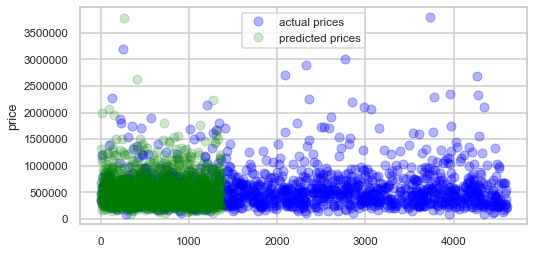

In [19]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(y_test_transformed, 'bo', alpha=0.3, label='actual prices')
ax.plot(predictions_dict['lr_pred3'], 'go', alpha=0.2, label='predicted prices')
#ax.set_xlabel('')
ax.set_ylabel('price')
ax.legend()
plt.show()

Text(0, 0.5, 'predicted prices')

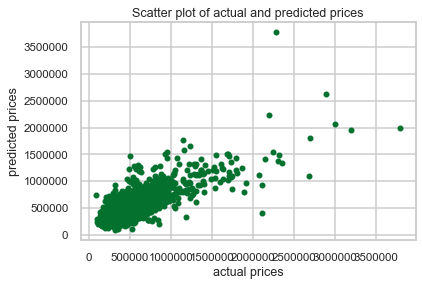

In [20]:
plt.scatter(y_test_transformed, predictions_dict['lr_pred3'], s=20)
plt.title('Scatter plot of actual and predicted prices')
plt.xlabel('actual prices')
plt.ylabel('predicted prices')

We see in the above plot that the predicted prices are somewhat close to the actual prices, but not very close. The best case scenario would be for the scatter plots to follow a perfectly straight diagonal line, indicating that our model perfectly predicted the house prices.

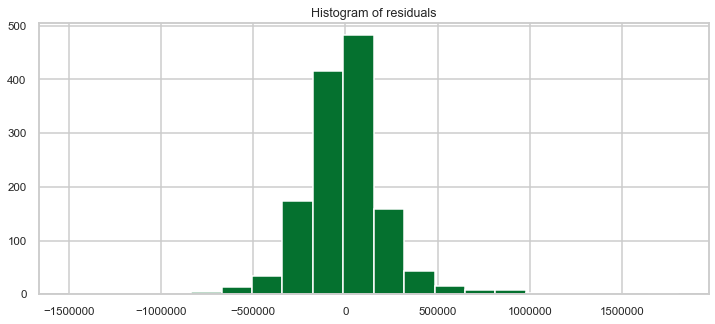

In [21]:
plt.subplots(figsize=(12,5))
plt.hist(y_test_transformed - predictions_dict['lr_pred3'], bins=20)
plt.title('Histogram of residuals')
plt.show()

The residual histogram somewhat follows a normal distribution, which is what we want because it tells us that we've chosen an appropriate model type, but there is a lot of room for improvement.

### CI around my prediction accuracy

calculate standard error RMSE
..

In [22]:
# RMSE == standard deviation of errors
rf_test_error

[816836.425, 214092.571, 224871.944, 224093.996]

In [23]:
one_sd = min(rf_test_error)
two_sd = 2*one_sd
three_sd = 3*one_sd

#### 68% Confidence

In [24]:
min_error = 0 - one_sd
max_error = 0 + one_sd

print('I can be 68% confident that the error in the home price predictions will be between {} and {}.'.format(min_error, max_error))

I can be 68% confident that the error in the home price predictions will be between -214092.571 and 214092.571.


#### 95% Confidence

In [25]:
min_error = 0 - two_sd
max_error = 0 + two_sd

print('I can be 95% confident that the error in the home price predictions will be between {} and {}.'.format(min_error, max_error))

I can be 95% confident that the error in the home price predictions will be between -428185.142 and 428185.142.


### Result Analysis

The following analysis is based on my 68% confidence that the error in the home price predictions is between -218832.738 and 218832.738:

If I've predicted a house to be $\$$400,000 and someone were to buy the house at that price, the worst loss would be \\$181,168 (400,000-218,832), and the highest gain would be \\$618,832 (400,000+218,832).

Let's say my boss wants to buy a house at below my estimate in the hopes of flipping it, i.e., selling the house at around double the price at which he acquired it. With a house that I have estimated to be \\$400,000, if he purchases it at \\$300,000 for example, 3 things can happen:

1. My estimation is correct and he will make a profit of \\$100,000 by just acquiring it, and could make another \\$300,000 by flipping it, making that a total profit of \\$400,000. 
2. The house is actually worth \\$181,168 and he ends up buying at a higher price than what the house is worth, losing \\$118,832 on the purchase.
3. The house is actually worth \\$618,832 and he ends up buying \\$318,832 below the house value, resulting in a 106%  profit just from acquiring it. Meaning, after investing \\$300,000, and expecting to make a profit of \\$200,000-\\$300,000 by flipping it, he ends up making a profit of \\$318,832 instead by just acquiring it, and another \\$300,000 by flipping it, making that a total of \\$618,832 of profit.

Now my boss purchased 100 homes at \$1000 less than my estimated price of \\$400,000:

His **average gain** would be \\$100,000.

His **worst loss** -- with actual price: \\$181,168 (i.e., 400,000-218,832), purchase price: \\$399,000  
\\$21,783,200

    difference between purchase price & actual price: 399,000 - 181,168 = 217,832
    for 100 homes: 217,832*100 = $21,783,200

His **highest gain** -- with actual price: \\$618,832 (i.e., 400,000+218,832), purchase price: \\$399,000  
\\$21,983,200

    difference between actual price & purchase price: 618,832 - 399,000 = 219,832
    for 100 homes 100: 219,832*100 = $21,983,200
    

In [29]:
# manual approach

from math import sqrt

np.random.seed(47)
n = 100 # length of sample
N_rep = 1000 # number of times to bootstrap/resample

def draw_bs_reps(y_test, y_pred):
    bs_residual = np.random.choice(y_test - y_pred, n) # price bought (true price)
    
    error_mean = np.sum(bs_residual) / len(bs_residual)
    return error_mean

error_means = np.array([draw_bs_reps(y_test_transformed, predictions_dict['rf_pred3']) for i in range(1000)]) # Random Forest model
error_means_mean = np.mean(error_means) # mean of means
print('mean of means: {}'.format(error_means_mean))

error_means_std = sqrt(np.sum((error_means-error_means_mean)**2) / (1000-1)) # standard deviation of means
print('std of means: {}'.format(error_means_std))

# confidence interval
min_error = error_means_mean - error_means_std
max_error = error_means_mean + error_means_std

print('The above result means that if I calculate the error between the true/historical price and my predicted price ' 
      'of 100 homes 1000 times, I can be 95% confident that the error of the mean of average error in the home price ' 
      'predictions will be between {} and {}.'.format(min_error, max_error))



mean of means: 3400.5794119125135
std of means: 23600.228574830653
The above result means that if I calculate the error between the true/historical price and my predicted price of 100 homes 1000 times, I can be 95% confident that the error of the mean of average error in the home price predictions will be between -20199.64916291814 and 27000.807986743166.


### Notes

**SE Coef**  
The standard error of the coefficient estimates the variability between coefficient estimates that you would obtain if you took samples from the same population again and again. The calculation assumes that the sample size and the coefficients to estimate would remain the same if you sampled again and again.

**Interpretation**  
Use the standard error of the coefficient to measure the precision of the estimate of the coefficient. The smaller the standard error, the more precise the estimate. Dividing the coefficient by its standard error calculates a t-value. If the p-value associated with this t-statistic is less than your significance level, you conclude that the coefficient is statistically significant.

Regression Analysis: Insolation versus South, North, Time of Day


Coefficients

Term          Coef  SE Coef  T-Value  P-Value   VIF
Constant       809      377     2.14    0.042
South        20.81     8.65     2.41    0.024  2.24
North        -23.7     17.4    -1.36    0.186  2.17
Time of Day  -30.2     10.8    -2.79    0.010  3.86

In this model, North and South measure the position of a focal point in inches. The coefficients for North and South are similar in magnitude. The standard error of the coefficient for South is smaller than the standard error of the coefficient for North. Therefore, the model is able to estimate the coefficient for South with greater precision.

The standard error of the North coefficient is nearly as large as the value of the coefficient itself. The resulting p-value is greater than common levels of the significance level, so you cannot conclude that the coefficient for North differs from 0.

While the coefficient for South is closer to 0 than the coefficient for North, the standard error of the coefficient for South is also smaller. The resulting p-value is smaller than common significance levels. Because the estimate of the coefficient for South is more precise, you can conclude that the coefficient for South differs from 0.

Statistical significance is one criterion you can use to reduce a model in multiple regression.

**Confidence Interval for coefficient (95% CI)**

These confidence intervals (CI) are ranges of values that are likely to contain the true value of the coefficient for each term in the model.

Because samples are random, two samples from a population are unlikely to yield identical confidence intervals. However, if you take many random samples, a certain percentage of the resulting confidence intervals contain the unknown population parameter. The percentage of these confidence intervals that contain the parameter is the confidence level of the interval.

The confidence interval is composed of the following two parts:

**Point estimate**
This single value estimates a population parameter by using your sample data. The confidence interval is centered around the point estimate.

**Margin of error**
The margin of error defines the width of the confidence interval and is determined by the observed variability in the sample, the sample size, and the confidence level. To calculate the upper limit of the confidence interval, the margin of error is added to the point estimate. To calculate the lower limit of the confidence interval, the margin of error is subtracted from the point estimate.

**Interpretation**
Use the confidence interval to assess the estimate of the population coefficient for each term in the model.

For example, with a 95% confidence level, you can be 95% confident that the confidence interval contains the value of the coefficient for the population. The confidence interval helps you assess the practical significance of your results. Use your specialized knowledge to determine whether the confidence interval includes values that have practical significance for your situation. If the interval is too wide to be useful, consider increasing your sample size.

**P-Value – Coefficient**

The p-value is a probability that measures the evidence against the null hypothesis. Lower probabilities provide stronger evidence against the null hypothesis.

**Interpretation**
To determine whether the association between the response and each term in the model is statistically significant, compare the p-value for the term to your significance level to assess the null hypothesis. The null hypothesis is that the term's coefficient is equal to zero, which implies that there is no association between the term and the response. Usually, a significance level (denoted as α or alpha) of 0.05 works well. A significance level of 0.05 indicates a 5% risk of concluding that an association exists when there is no actual association.

**P-value ≤ α: The association is statistically significant**  
If the p-value is less than or equal to the significance level, you can conclude that there is a statistically significant association between the response variable and the term.

**P-value > α: The association is not statistically significant**  
If the p-value is greater than the significance level, you cannot conclude that there is a statistically significant association between the response variable and the term. You may want to refit the model without the term.

If there are multiple predictors without a statistically significant association with the response, you can reduce the model by removing terms one at a time. For more information on removing terms from the model, go to Model reduction.

If a model term is statistically significant, the interpretation depends on the type of term. The interpretations are as follows:  
If a coefficient for a continuous variable is significant, changes in the value of the variable are associated with changes in the mean response value.